코랩 런타임 > 런타임 유형 변경 GPU 로 설정 후 과제 진행해주세요 !

# < 4주차 과제 >
- 원하는 구조를 가진 CNN을 구축할 수 있다
- 실전적인 이미지 데이터셋을 활용하여 분류 Task를 수행해보자.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Baseline (복습)

In [17]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [18]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

데이터셋은 28*28로 이루어져있음

(입력이미지 높이(너비) - 컨볼루션 커널의 높이(너비) + 2*패딩의양) / 스트라이드 높이(너비) + 1

self.conv1 = nn.Conv2d(1, 10, kernel_size = 5) # 총 10개의 채널이 output, filter = 5*5, stride=1, padding=0, input채널 = 1(흑백) -> output : 24 * 24 (*10)

이후 pooling -> 커널이 2이므로 conv1 & pooling -> 12 * 12 (*10)

self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) # 10개의 channel을 넣고 20개의 channel이 output, filter = 5*5
output : 8 * 8 (*20)

이후 pooling -> 커널 2이므로 conv2 & pooling -> 4 * 4 (*20)


In [29]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5) # 총 10개의 채널이 output, filter = 5*5, stride=1, padding=0, input채널 = 1(흑백)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) # 10개의 channel을 넣고 20개의 channel이 output, filter = 5*5

    self.mp = nn.MaxPool2d(2) #커널의 크기가 2
    self.fc = nn.Linear(320 , 10) ### : 알맞는 input은? 4*4*20

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    x = x.view(in_size, -1)
    x = self.fc(x)
    return F.log_softmax(x)

Q : 'super(Net, self).__ init __()'

super(class이름, sef)꼴로 사용 = super.__ init__ (class이름, self)

class내에서 torch.nn모듈을 사용할 때 해당 코드가 없다면 attribute Error 발생함

torch.nn이 없다면 super 부분 없어도됨

super - 상속받은 부모 클래스, 즉 부모 클래스를 불러와 init을 수행함 = 부모클래스의 생성자를 불러주는 것을 의미한다. = 다양한 변수들이 선언되었을 때 해당 변수들을 상속받는 역할을 해주는 것.

Q : view

reshape, view모두 텐서 모양 변경에 사용되며 문법은 동일하 차이점 존재

reshape : input의 view를 반환하며, 이것이 불가능하면 연속적(=contigous)인 tensor로 copy -> view를 반환

view : 기존 데이터와 같은 메모리 공간 공유, stride 크기만 변경하여 보여주는 것만 다르게 함. 연속적이어야 동작 (아닐 경우 error)


=> view는 메모리가 기존 텐서와 동일한 메모리를 공유하는 것이 보장되나 reshape은 그렇지 않다.

1. 안전하게 형태만 변경이 목적 ; reshape

2. 메모리 공유되어 업데이트가 되는 것이 목적 ; view

contiguous tensor : 요소들이 선형적이고 연속적인 방식으로 메모리에 저장되는 텐서로, 각 텐서 내 요소들의 메모리 주소가 간격 혹은 불연속성없이 순차적 증가하는 꼴

이때, view해주는 이유는 linear함수 내의 input으로 적절하게 들어가기 위함.

[참고자료]

https://cnu-jinseop.tistory.com/185 - super

https://anweh.tistory.com/12 - view

https://subinium.github.io/pytorch-Tensor-Variable/ - view vs reshape

https://discuss.pytorch.kr/t/contiguous-tensor/889 - contiguous tensor

https://wikidocs.net/52846 - view목적

In [30]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [32]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target) #손실함수 지정
    loss.backward()
    optimizer.step() #update
    if batch_idx % 10 == 0: #미니 배치 인덱스가 10의 배수이면 훈련 상태 print
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [33]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

**nll_loss**

negative log likelihood(NLL) 손실 함수

주로 다중 클래스 분류 문제에 사용되며 cross entropy loss와 같이 모델의 output 분포와 실제 label사이의 차이를 측정하여 loss를 정의

따라서 모델의 output은 로그 확률로 주어져야하며, 타깃 label은 정수로 주어져야 함.

NLL 손실은 실제 label에 해당하는 로그 확률의 음수값으로 정의됨 ( 잘 맞출수록 손실 값 낮아짐)


```
torch.nn.NLLLoss(weight=None, ignore_index=-100, reduction='mean')
```

weight : 클래스에 대한 가중치 지정 (클래스 불균형 처리시 사용됨) 기본값 None을 사용하면 동일한 가중치 사용

ignore_index : 손실 계산시 무시할 인덱스 지정 / 기본값은 -100임

reduction : 손실값을 어떻게 줄일지 지정 / mean이 기본값 / sum, none 옵션


cross entropy vs nll

구현 함수에서의 차이점 존재

cross entropy -> logmax적용 후 nll loss 적용식과 동일

즉, log or softmax가 적용되지 않은 ouput을 input으로 받는 것이 cross entropy

nll loss -> softmax log 등이 해당 함수 내에서 적용 X 따라서 log softmax함수 적용한 값을 input으로 받음


[참고자료]

https://wikidocs.net/194925

https://supermemi.tistory.com/entry/Loss-Cross-Entropy-Negative-Log-Likelihood-%EB%82%B4%EC%9A%A9-%EC%A0%95%EB%A6%AC-Pytorch-Code

In [28]:
for epoch in range(1, 10):
    train(epoch)
    test()

<ipython-input-24-b96919e1004e>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301591
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.292956
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.267130
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.256129
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.242188
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.224756
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.178957
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.139065
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.053314
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.903768
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.866454
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.649891
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.199685
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.237903
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.948518
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.940934
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.814350
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.699816
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.565031
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.742211
Train Epoch: 1 [12800/60000 (

<ipython-input-27-6ed0d2a1801a>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1736, Accuracy: 9502/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.096820
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.250805
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.113120
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.207515
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.205622
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.260125
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.339890
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.334617
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.259355
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.092637
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.053999
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.164370
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.384403
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.286858
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.081916
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.156381
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.092806
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.093711
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.064653
Train Epoch: 2 [12

# [4주차 과제 1 : CNN structure 구현하기]
- 3주차 과제에서 맛보았던 baseline 코드를 바탕으로,
- 첨부한 이미지의 structure를 구현해주세요!

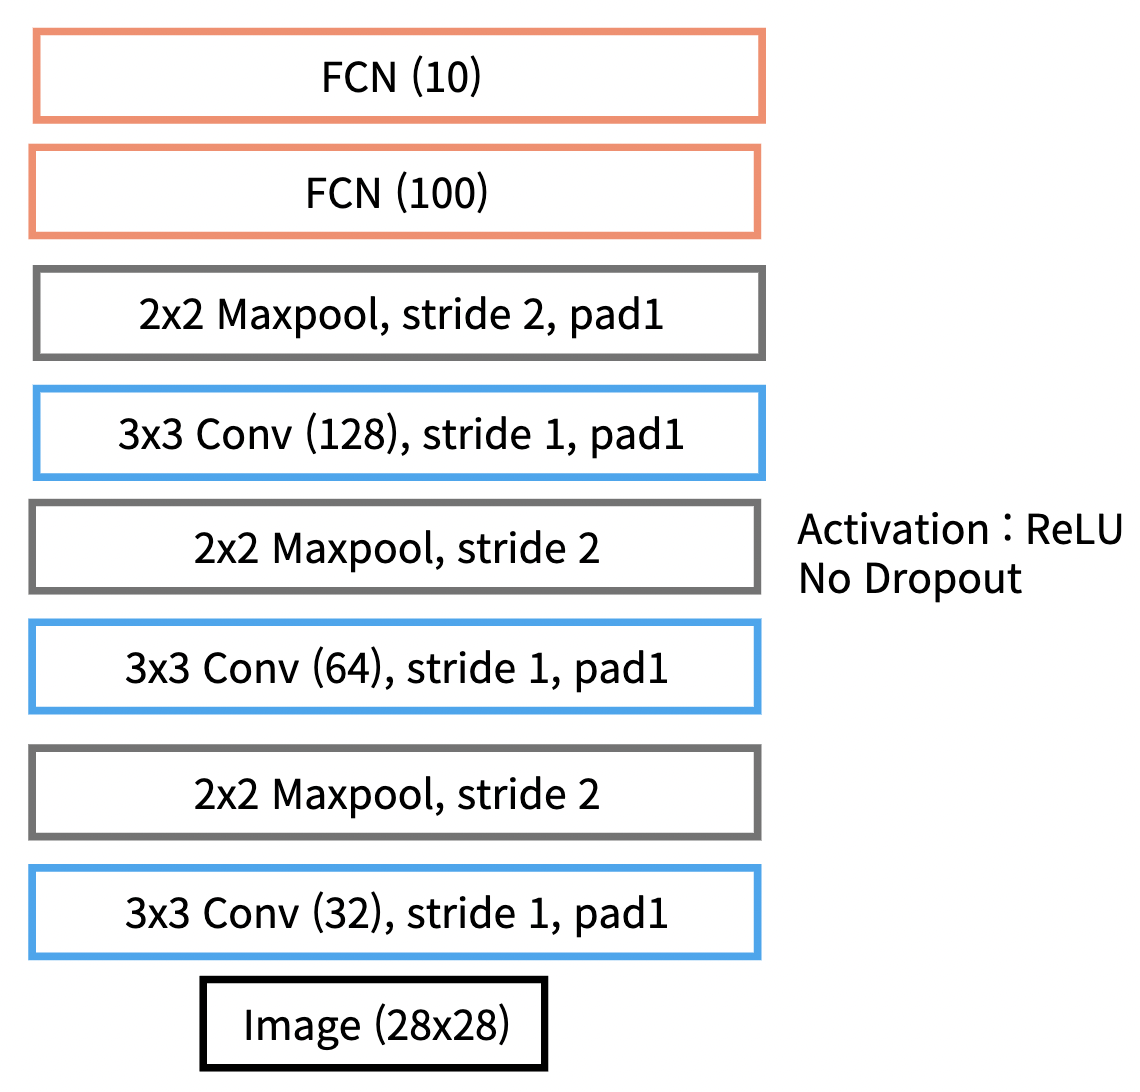

1. conv1 -> output : (28-3 +2*1)/1 + 1 = 28

-> pooling -> 14* 14 (*32)

2. conv2 -> output : (14 - 3 + 2*1)/1 + 1 = 14

-> pooling -> 7 * 7 (*64)

3. conv3 -> output : (7 - 3 + 2*1)/1 + 1 = 7
-> pooling -> 4* 4 (*128) (padding때문)

In [34]:
class revised_Net(nn.Module):
  def __init__(self):
    super(revised_Net, self).__init__()
    #convolution
    self.conv1 = nn.Conv2d(1,32,kernel_size=3, stride=1, padding=1) #output channel = 32 -> 다음 convolution layer input channel수와 동일
    self.conv2 = nn.Conv2d(32,64,kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64,128,kernel_size=3,stride=1, padding=1)

    #pooling
    self.mp1 = nn.MaxPool2d(2, stride=2)
    self.mp2 = nn.MaxPool2d(2, stride=2, padding=1)

    #fc
    self.fc1 = nn.Linear(4*4*128,100)
    self.fc2 = nn.Linear(100,10)

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp1(self.conv1(x)))
    x = F.relu(self.mp1(self.conv2(x)))
    x = F.relu(self.mp2(self.conv3(x)))
    x = x.view(in_size,-1) #flatten시켜줘야하기 때
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x)


In [35]:
model = revised_Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [36]:
for epoch in range(1, 10):
    train(epoch)
    test()

<ipython-input-34-938541626848>:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313394
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.306630
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.307183
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.297090
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.302134
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.298267
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.297728
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.305006
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.294895
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.292478
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.291178
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.288920
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.285046
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.286583
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.281060
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.271435
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.279255
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.290536
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.278510
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.277099
Train Epoch: 1 [12800/60000 (

<ipython-input-35-252edfe1b05a>:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2278, Accuracy: 9294/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.433371
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.359554
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.220518
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.137760
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.133939
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.220386
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.231713
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.237519
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.281767
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.121046
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.215404
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.125224
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.204417
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.308962
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.258849
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.432867
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.312659
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.276596
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.159877
Train Epoch: 2 [12

# [4주차 과제 2 : CNN 활용하기]
- CIFAR 10 데이터셋을 사용하여,
- CNN을 직접 구현하며, 분류 task를 수행해봅시다.

* 지난번 과제와 마찬가지로 다양한 방식을 시도해보시고 그 시도 기록을 남겨주세요. 가장 성능이 좋았던 모델도 표시해주세요

* 이번엔 GPU resource 문제가 생길 수 있습니다. 파라미터 조정, dropout 추가, layer 수 조정 등 연산 효율성도 고려해서 베이스라인 조정해보세요

In [37]:
import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#랜덤 시드 고정 : 학습을 위한 실험을 할 때 무작위성을 컨트롤하기 위해 사용.
torch.manual_seed(777) #cpu 연산 고정

if device == "cuda:0":
    torch.cuda.manual_seed_all(777) # 멀티 gpu 연산 무작위 고정

import time
import copy

from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

In [38]:
# Data Augmentation, Transform의 기능은?
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.RandomCrop(227), #227 * 227
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

- Augmentation

: 데이터 증강, 학습 데이터를 변형시켜 새로운 데이터를 생성 -> 모델의 일반화 성능을 향상시키는 데 도움이됨 (모델에 다양한 데이터 제공)

: 이미지 데이터에서 이미지 회전, 이동, 반전 등의 변형을 줘 새로운 이미지 생성

: pytorch 내에서 자체적인 증강 기능을 제공하지는 않으나, 다양한 라이브러리와 함께 사용 가능 - 대표적으로 transform 라이브러리

torchvision.transform에서 randomrotation(이미지회전), randomaffine(이미지 이동), randomchoice(이미지 상하/좌우 반전), resize(이미지 크기조정)


* resize

: resize(size1,size2)꼴로 사용

size1만 지정하면 이미지 가로 세로 중 짧은 부분을 인자로 맞추고 큰 부분은 비율을 유지하면서 변경

2개 모두 지정하면 해당 값에 따라 사이즈 변

* randomcrop

: randomcrop(size) 꼴로 사용

이미지를 임의의 위치에서 자름 (size*size로)

centorcrop도 존재함 (중간 위치 기준 crop)

* normalize

: 각 채널의 평균, 표준편차를 넣어주어 정규화 (채널수에 맞게 평균, 표준편차 넣어줌)

*ToTensor

: 파이토치의 배열 구조 -> 채널 * 높이 * 너비

pil / numpy배열 구조 -> 높이 * 너비 * 채널

totensor는 이런 데이터의 구조를 변경하며, 이미지 픽셀 밝기 정도를 scale해줌

0 ~ 255의 밝기 -> 0 ~ 1로 scale



[참고자료]

https://gr-st-dev.tistory.com/2030

https://cnu-jinseop.tistory.com/187

In [89]:
batch_size = 64 #batch_size는 원하는 크기로 변경 가능.

cifar_train = datasets.CIFAR10('~/.data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)

cifar_test = datasets.CIFAR10('~/.data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

data_loaders = {'train' : train_loader, 'val': test_loader}
total_batch = {'train' : len(train_loader), 'val': len(test_loader)}

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [90]:
cifar_train.data.shape # 32*32, RGB

(50000, 32, 32, 3)

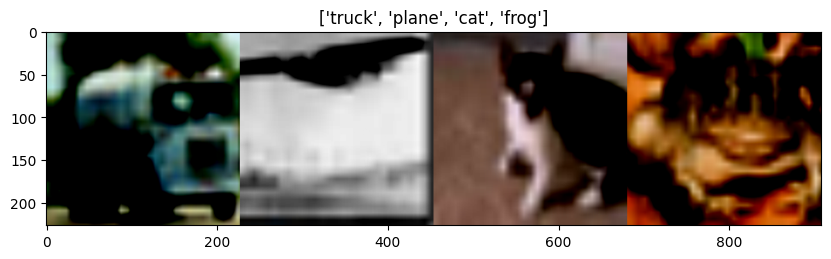

In [91]:

from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

dataiter       = iter(train_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter)   # next함수로 다음 배치 1개 갖고오기

img   = utils.make_grid(images[:4], padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.title([classes[label] for label in labels[:4].tolist()])
plt.show()

CNN -> relu 계열이 잘 작동

activation

relu / leaky relu / prelu / elu

- leaky relu

: relu가 죽는 뉴런이 죽는 현상을 해결하기 위해 나옴 / max(0.01x,x) / 0.01대신 매우 작은 값이면 무엇이든 사용 가능 / x가 음수인 영역값에서 미분값이 0이 되지 않는다는 점이 차이

- prelu

: leaky relu와 거의 유사하지만 새로운 파라미터를 추가해 x가 음수인 영역에서도 기욹기 학습 / max(alpha*x,x)

- elu (exponential linear unit)

: relu의 모든 장점을 포함해 뉴런이 죽는 현상을 해결, 출력값이 거의 zero-centered에 가까움

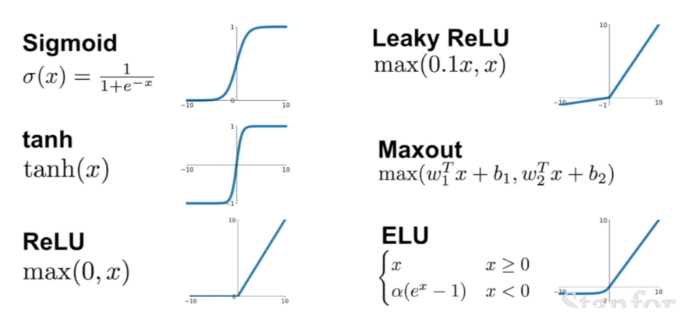

[참고자료]

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=handuelly&logNo=221824080339

CNN 구성은 다른 사람들의 코드 참고

dropout :  fc 전후에 설계해 계산복잡도와 오버피팅 가능성을 낮출 수 있음

https://olivia-blackcherry.tistory.com/360

https://www.dinolabs.ai/198

## CNN1 (relu + dropoutX)

In [134]:
class CNN1(nn.Module):
  def __init__(self):
    super(CNN1, self).__init__()
    #convolution
    self.conv1 = nn.Conv2d(3, 12, kernel_size = 3, padding=1) #32*32
    self.conv2 = nn.Conv2d(12, 24, kernel_size= 3, padding =1) #16*16
    self.conv3 = nn.Conv2d(24, 36, kernel_size=3, padding=1) #8*8

    #pooling
    self.mp = nn.MaxPool2d(2)

    #fc
    self.fc1 = nn.Linear(28224,36) #input..?
    self.fc2 = nn.Linear(36,10)

  def forward(self,x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    x = F.relu(self.mp(self.conv3(x)))
    x = x.view(in_size,-1)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x,dim=1)


In [135]:
model = CNN1()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [136]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output,target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))


In [137]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [138]:
print("Train Loader Batch Size:", train_loader.batch_size)
print("Test Loader Batch Size:", test_loader.batch_size)

Train Loader Batch Size: 64
Test Loader Batch Size: 64


In [1]:
for epoch in range(1, 5):
    train(epoch)
    test()

NameError: name 'train' is not defined

## CNN2 (relu + dropout)

https://www.dinolabs.ai/198

https://wikidocs.net/196790

https://velog.io/@convin305/%EB%85%BC%EB%AC%B8%EB%A6%AC%EB%B7%B0-dropout%EC%9D%84-%ED%86%B5%ED%95%9C-CNN%EB%AA%A8%EB%8D%B8-%ED%96%A5%EC%83%81%EC%8B%9C%ED%82%A4%EA%B8%B0

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [100]:
batch_size = 64 #batch_size는 원하는 크기로 변경 가능.

cifar_train = datasets.CIFAR10('~/.data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)

cifar_test = datasets.CIFAR10('~/.data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

data_loaders = {'train' : train_loader, 'val': test_loader}
total_batch = {'train' : len(train_loader), 'val': len(test_loader)}

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter       = iter(train_loader)
images, labels = next(dataiter)

Files already downloaded and verified
Files already downloaded and verified


In [98]:
model1 = Sequential([
                     Conv2D(64,(5,5),padding='same',input_shape=(32,32,3),activation='relu'),
                     MaxPooling2D((3,3),2),

                     Conv2D(64,(5,5),padding='same',activation='relu'),
                     AveragePooling2D((3,3),2),

                     Conv2D(64,(5,5),padding='same',activation='relu'),
                     AveragePooling2D((3,3),2),

                     Flatten(),
                     Dense(10,activation='softmax')
])

NameError: name 'models' is not defined

## CNN3 (leaky relu)

In [ ]:
batch_size = 64 #batch_size는 원하는 크기로 변경 가능.

cifar_train = datasets.CIFAR10('~/.data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)

cifar_test = datasets.CIFAR10('~/.data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

data_loaders = {'train' : train_loader, 'val': test_loader}
total_batch = {'train' : len(train_loader), 'val': len(test_loader)}

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter       = iter(train_loader)
images, labels = next(dataiter)

In [101]:
class CNN3(nn.Module):
  def __init__(self):
    super(CNN3, self).__init__()
    #convolution
    self.conv1 = nn.Conv2d(3, 12, kernel_size = 3, padding=1) #32*32
    self.conv2 = nn.Conv2d(12, 24, kernel_size= 3, padding =1) #16*16
    self.conv3 = nn.Conv2d(24, 36, kernel_size=3, padding=1) #8*8

    #pooling
    self.mp = nn.MaxPool2d(2)

    #fc
    self.fc1 = nn.Linear(28224,36)
    self.fc2 = nn.Linear(36,10)

  def forward(self,x):
    in_size = x.size(0)
    x = F.LeakyReLU(self.mp(self.conv1(x)))
    x = F.LeakyReLU(self.mp(self.conv2(x)))
    x = F.LeakyReLU(self.mp(self.conv3(x)))
    x = x.view(-1,4*4*36)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x)


In [ ]:
model = CNN3()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output,target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

for epoch in range(1, 5):
    train(epoch)
    test()

## CNN4 (prelu)

In [ ]:
batch_size = 64 #batch_size는 원하는 크기로 변경 가능.

cifar_train = datasets.CIFAR10('~/.data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)

cifar_test = datasets.CIFAR10('~/.data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

data_loaders = {'train' : train_loader, 'val': test_loader}
total_batch = {'train' : len(train_loader), 'val': len(test_loader)}

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter       = iter(train_loader)
images, labels = next(dataiter)

In [102]:
class CNN4(nn.Module):
  def __init__(self):
    super(CNN4, self).__init__()
    #convolution
    self.conv1 = nn.Conv2d(3, 12, kernel_size = 3, padding=1) #32*32
    self.conv2 = nn.Conv2d(12, 24, kernel_size= 3, padding =1) #16*16
    self.conv3 = nn.Conv2d(24, 36, kernel_size=3, padding=1) #8*8

    #pooling
    self.mp = nn.MaxPool2d(2)

    #fc
    self.fc1 = nn.Linear(28224,36)
    self.fc2 = nn.Linear(36,10)

  def forward(self,x):
    in_size = x.size(0)
    x = F.PReLU(self.mp(self.conv1(x)))
    x = F.PReLU(self.mp(self.conv2(x)))
    x = F.PReLU(self.mp(self.conv3(x)))
    x = x.view(-1,4*4*36)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x)

In [ ]:
model = CNN4()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output,target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

for epoch in range(1, 5):
    train(epoch)
    test()

## CNN5 (elu)

In [ ]:
batch_size = 64 #batch_size는 원하는 크기로 변경 가능.

cifar_train = datasets.CIFAR10('~/.data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)

cifar_test = datasets.CIFAR10('~/.data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

data_loaders = {'train' : train_loader, 'val': test_loader}
total_batch = {'train' : len(train_loader), 'val': len(test_loader)}

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter       = iter(train_loader)
images, labels = next(dataiter)

In [ ]:
class CNN5(nn.Module):
  def __init__(self):
    super(CNN5, self).__init__()
    #convolution
    self.conv1 = nn.Conv2d(3, 12, kernel_size = 3, padding=1) #32*32
    self.conv2 = nn.Conv2d(12, 24, kernel_size= 3, padding =1) #16*16
    self.conv3 = nn.Conv2d(24, 36, kernel_size=3, padding=1) #8*8

    #pooling
    self.mp = nn.MaxPool2d(2)

    #fc
    self.fc1 = nn.Linear(28224,36)
    self.fc2 = nn.Linear(36,10)

  def forward(self,x):
    in_size = x.size(0)
    x = F.ELU(self.mp(self.conv1(x)))
    x = F.ELU(self.mp(self.conv2(x)))
    x = F.ELU(self.mp(self.conv3(x)))
    x = x.view(-1,4*4*36)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x)

In [ ]:
model = CNN5()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output,target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

for epoch in range(1, 5):
    train(epoch)
    test()